# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Functions

In [3]:
def load_and_prepare(filename:str, columns:list[str]=["value", "kubernetes_pod_name", "topic"]) -> pd.DataFrame:
    """Loads a parquet file and ensures timestamp is index."""
    if not os.path.exists(filename):
        print(f"File {filename} not found.")
        raise Exception("File not Found")
    
    df = pd.read_parquet(filename)
    df = df[columns]

    df.index = df.index.to_series() - pd.Timedelta(hours=3)

    df = df[
            (df.index > START_TIME) &
            (df.index < END_TIME)
        ]

    #Usually index is the timestamp from Prometheus
    return df.sort_index()

def calculate_rate(df: pd.DataFrame, value_col='value', columns:list[str]=["kubernetes_pod_name", "topic"]) -> pd.Series:
    """Calculates the rate per second for counter metrics."""
    # Group by labels (topic, instance, etc.) to calculate rates correctly
    group_cols = columns
    
    def get_rate(group):
        # Rate = (val_t2 - val_t1) / (time_t2 - time_t1 in seconds)
        delta_val = group[value_col].diff()
        delta_time = group.index.to_series().diff().dt.total_seconds()
        # If delta_val is negative, the prometheus counter reset. 
        # We treat the new value as the actual increase for that interval
        rate = delta_val / delta_time
        rate.loc[delta_val < 0] = group.loc[delta_val < 0, value_col] / delta_time.loc[delta_val < 0]
        return rate

    return df.groupby(group_cols, group_keys=False).apply(get_rate)

# Experiment Definitions

# Edge

In [4]:
START_TIME = pd.Timestamp('2026-01-05 15:30:00')
END_TIME = pd.Timestamp('2026-01-05 17:30:00')

In [5]:
data_folder = "../../data/raw/final-01/final-01_edge"

# List of files to analyze
files = {
    'messages': f'{data_folder}/kafka_server_brokertopicmetrics_messagesin_total.parquet',
    'bytes_in': f'{data_folder}/kafka_server_brokertopicmetrics_bytesin_total.parquet',
    'bytes_out': f'{data_folder}/kafka_server_brokertopicmetrics_bytesout_total.parquet',
    'lag': f'{data_folder}/kafka_server_replicafetchermanager_maxlag.parquet',
    'offsets': f'{data_folder}/kafka_topic_partition_current_offset.parquet',
    'io_ratio': f'{data_folder}/kafka_server_socket_server_metrics_io_ratio.parquet',
    'io_time': f'{data_folder}/kafka_server_socket_server_metrics_iotime.parquet'
}

## I/O Metrics

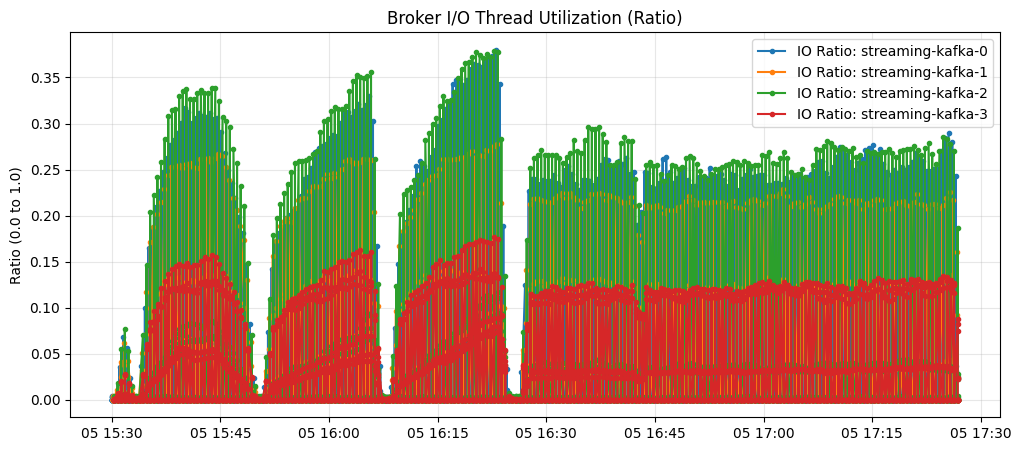

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Analyze IO Ratio (Busy-ness)
df_ratio = load_and_prepare(files['io_ratio'], columns=["kubernetes_pod_name", "value"])

plt.figure(figsize=(12, 5))
for pod, data in df_ratio.groupby('kubernetes_pod_name'):
    plt.plot(data.index, data['value'], label=f"IO Ratio: {pod}", marker='.')

plt.title("Broker I/O Thread Utilization (Ratio)")
plt.ylabel("Ratio (0.0 to 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

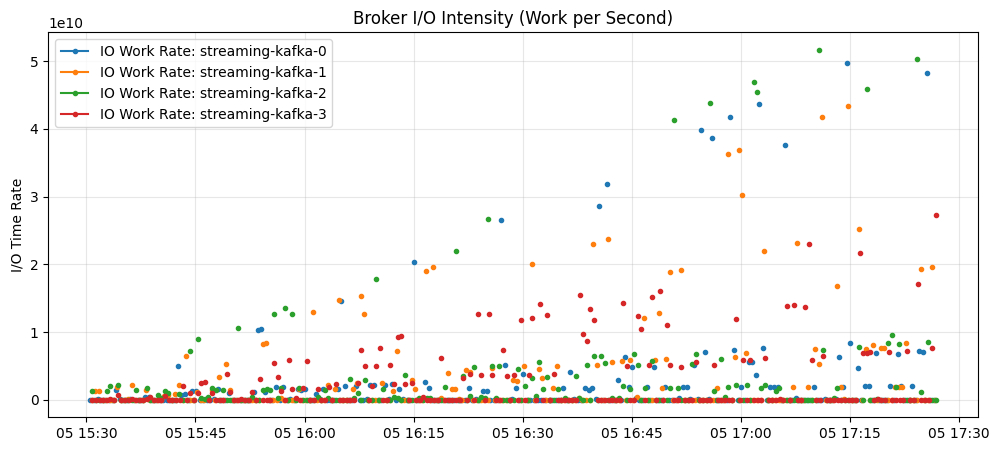

In [7]:
# 2. Analyze IO Time Rate
# IOTime is likely a counter, so we calculate the rate of change
df_iotime = load_and_prepare(files['io_time'], columns=["kubernetes_pod_name", "value"])

def calculate_io_rate(group):
    delta_val = group['value'].diff()
    delta_time = group.index.to_series().diff().dt.total_seconds()
    # Handle resets (negative delta)
    rate = delta_val / delta_time
    rate[delta_val < 0] = group['value'] / delta_time
    return rate

plt.figure(figsize=(12, 5))
for pod, data in df_iotime.groupby('kubernetes_pod_name'):
    # Ensure data is sorted for rate calculation
    data = data.sort_index()
    io_rate = calculate_io_rate(data)
    plt.plot(data.index, io_rate, label=f"IO Work Rate: {pod}", marker='.')

# plt.axvline(target_time_local, color='red', linestyle='--', label='Broker Restart')
plt.title("Broker I/O Intensity (Work per Second)")
plt.ylabel("I/O Time Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Messages Throughput

/tmp/ipykernel_273541/1266604371.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


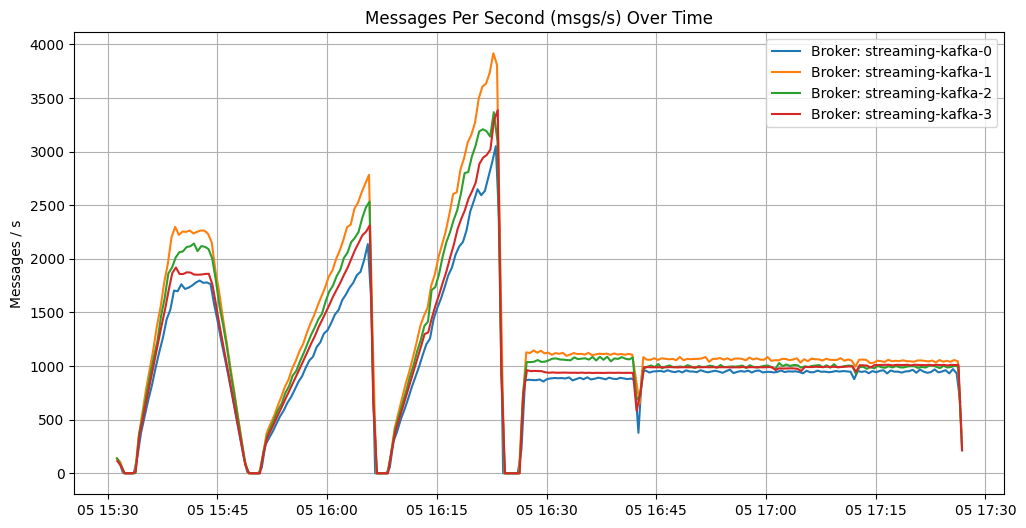

In [8]:
# 1. Analyze Messages Per Second (msgs/s)
df_msgs = load_and_prepare(files['messages'])
df_msgs = df_msgs[df_msgs["topic"] == "robot_data-avro"]
df_msgs = df_msgs.sort_values(["kubernetes_pod_name", "topic"])
if df_msgs is not None:
    df_msgs["rate"] = calculate_rate(df_msgs)

    df_msgs = df_msgs.dropna(subset=['rate'])
    
    plt.figure(figsize=(12, 6))
    for pod, data in df_msgs.groupby('kubernetes_pod_name'):
        plt.plot(data.index, data['rate'], label=f"Broker: {pod}")
    plt.title("Messages Per Second (msgs/s) Over Time")
    plt.ylabel("Messages / s")
    plt.legend()
    plt.grid(True)
    save_path = "../../data/processed/final-01/kafka_messages_per_second_edge.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_273541/1266604371.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)
/tmp/ipykernel_273541/1266604371.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


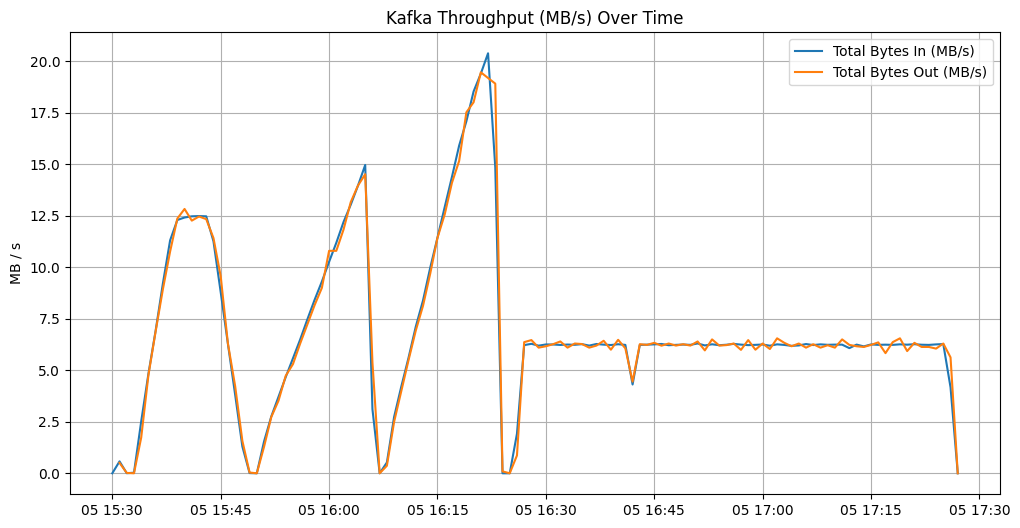

In [9]:
# 2. Analyze Bytes In and Out Over Time
df_bin = load_and_prepare(files['bytes_in'])
df_bin = df_bin[df_bin["topic"] == "robot_data-avro"]
df_bin = df_bin.sort_values(["kubernetes_pod_name", "topic"])
df_bout = load_and_prepare(files['bytes_out'])
df_bout = df_bout[df_bout["topic"] == "robot_data-avro"]
df_bout = df_bout.sort_values(["kubernetes_pod_name", "topic"])

if df_bin is not None and df_bout is not None:
    df_bin['bytes_in_per_sec'] = calculate_rate(df_bin)
    df_bout['bytes_out_per_sec'] = calculate_rate(df_bout)
    
    plt.figure(figsize=(12, 6))
    total_in = df_bin.resample('1Min')['bytes_in_per_sec'].sum()
    total_out = df_bout.resample('1Min')['bytes_out_per_sec'].sum()
    
    plt.plot(total_in.index, total_in / 1024**2, label="Total Bytes In (MB/s)")
    plt.plot(total_out.index, total_out / 1024**2, label="Total Bytes Out (MB/s)")
    plt.title("Kafka Throughput (MB/s) Over Time")
    plt.ylabel("MB / s")
    plt.legend()
    plt.grid(True)
    save_path = "../../data/processed/final-01/kafka_bytes_in_out_edge.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

## Broker Sync

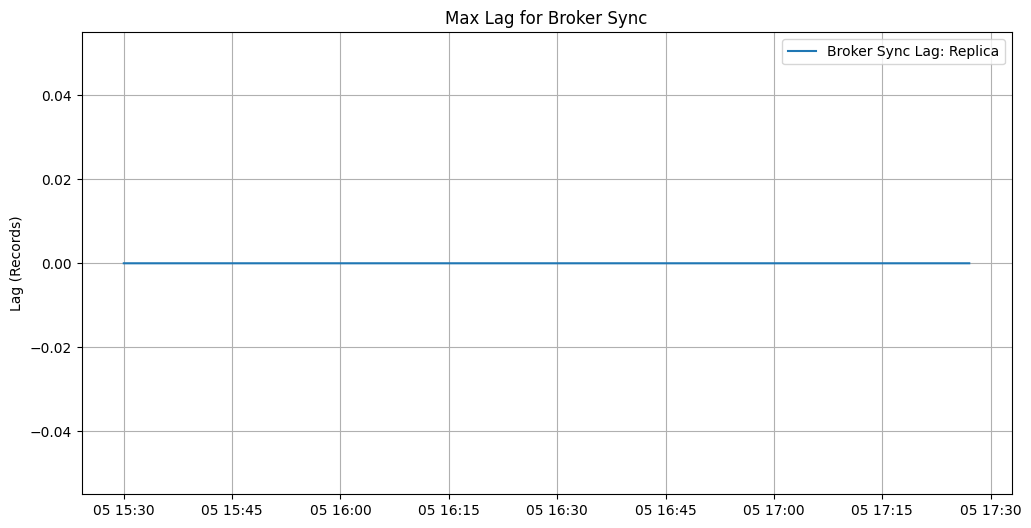

In [10]:
# 3. Analyze Lag for Broker Sync
df_lag = load_and_prepare(files['lag'], columns=["kubernetes_pod_name", "value", "clientId"])

if df_lag is not None:
    plt.figure(figsize=(12, 6))
    for client, data in df_lag.groupby('clientId'):
        plt.plot(data.index, data['value'], label=f"Broker Sync Lag: {client}")
    plt.title("Max Lag for Broker Sync")
    plt.ylabel("Lag (Records)")
    plt.legend()
    plt.grid(True)
    plt.show()

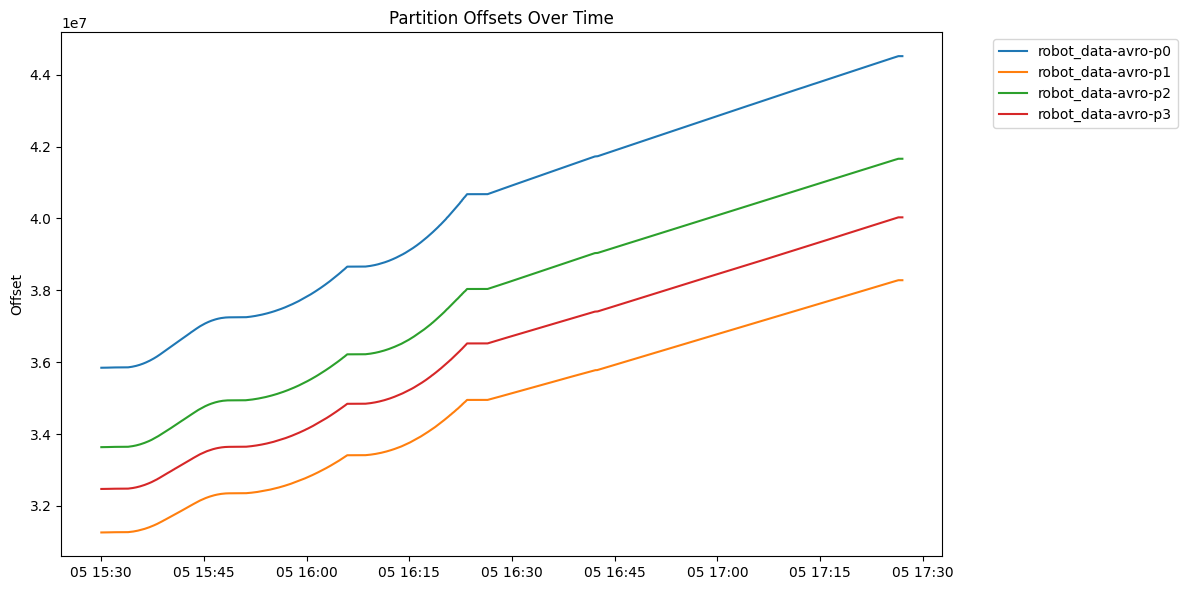

In [11]:
# 4. Offsets of Partitions Over Time
df_offsets = load_and_prepare(files['offsets'], columns=["value", "partition", "topic"])
df_offsets = df_offsets[df_offsets["topic"] == "robot_data-avro"]
if df_offsets is not None:
    plt.figure(figsize=(12, 6))
    # Plotting for a few specific partitions to avoid clutter
    for (topic, partition), data in df_offsets.groupby(['topic', 'partition']):
        plt.plot(data.index, data['value'], label=f"{topic}-p{partition}")
    plt.title("Partition Offsets Over Time")
    plt.ylabel("Offset")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Rerun

In [12]:
START_TIME = pd.Timestamp('2026-01-05 19:05:00')
END_TIME = pd.Timestamp('2026-01-05 19:40:00')

/tmp/ipykernel_273541/1266604371.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


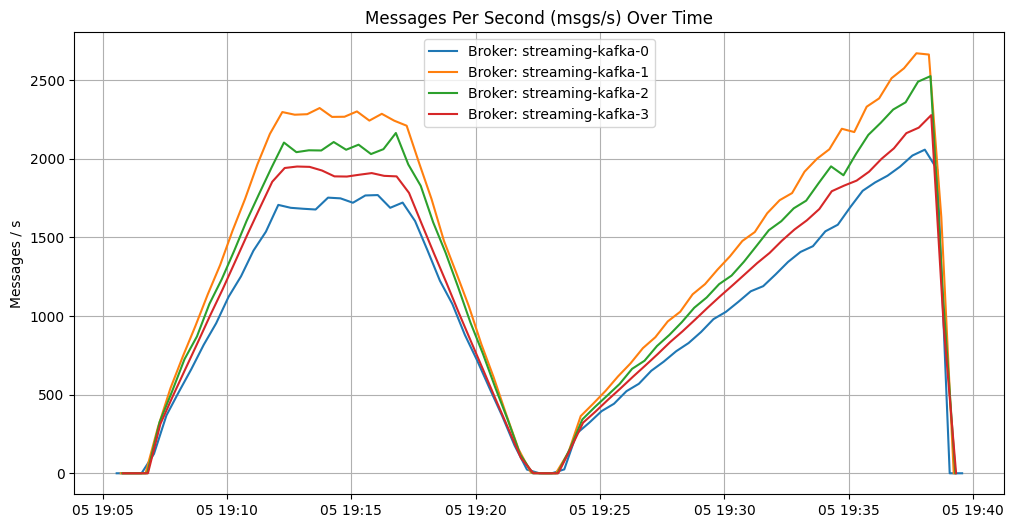

In [16]:
file_edge = "../../data/raw/final-01/rerun/final-01_edge/kafka_server_brokertopicmetrics_messagesin_total.parquet"

# 1. Analyze Messages Per Second (msgs/s)
df_msgs = load_and_prepare(file_edge)
df_msgs = df_msgs[df_msgs["topic"] == "robot_data-avro"]
df_msgs = df_msgs.sort_values(["kubernetes_pod_name", "topic"])
if df_msgs is not None:
    df_msgs["rate"] = calculate_rate(df_msgs)

    df_msgs = df_msgs.dropna(subset=['rate'])
    
    plt.figure(figsize=(12, 6))
    for pod, data in df_msgs.groupby('kubernetes_pod_name'):
        plt.plot(data.index, data['rate'], label=f"Broker: {pod}")
    plt.title("Messages Per Second (msgs/s) Over Time")
    plt.ylabel("Messages / s")
    plt.legend()
    plt.grid(True)
    save_path = "../../data/processed/final-01/kafka_messages_per_second_edge_rerun.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_273541/1266604371.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)
/tmp/ipykernel_273541/1266604371.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


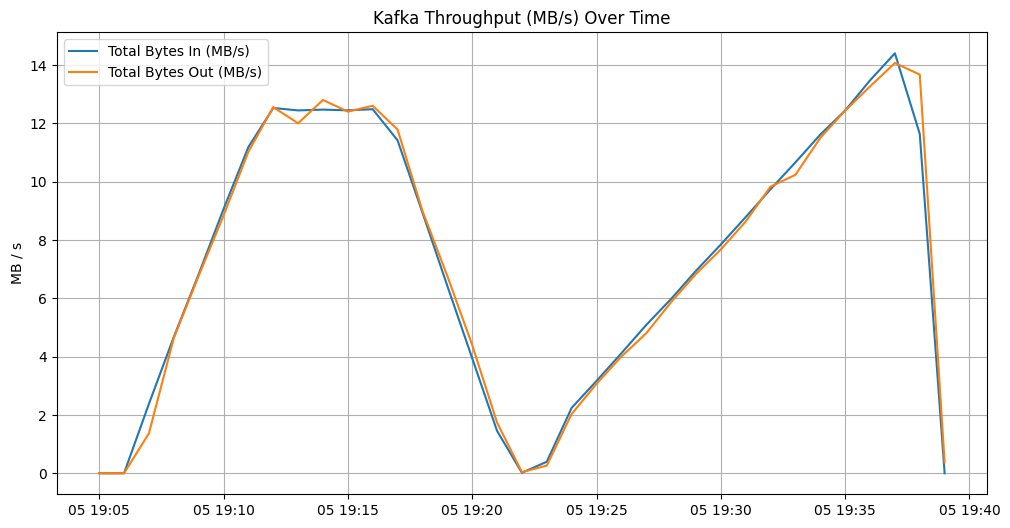

In [17]:
file_edge = "../../data/raw/final-01/rerun/final-01_edge/kafka_server_brokertopicmetrics_bytesin_total.parquet"
# 2. Analyze Bytes In and Out Over Time
df_bin = load_and_prepare(file_edge)
df_bin = df_bin[df_bin["topic"] == "robot_data-avro"]
df_bin = df_bin.sort_values(["kubernetes_pod_name", "topic"])

file_edge = "../../data/raw/final-01/rerun/final-01_edge/kafka_server_brokertopicmetrics_bytesout_total.parquet"
df_bout = load_and_prepare(file_edge)
df_bout = df_bout[df_bout["topic"] == "robot_data-avro"]
df_bout = df_bout.sort_values(["kubernetes_pod_name", "topic"])

if df_bin is not None and df_bout is not None:
    df_bin['bytes_in_per_sec'] = calculate_rate(df_bin)
    df_bout['bytes_out_per_sec'] = calculate_rate(df_bout)
    
    plt.figure(figsize=(12, 6))
    total_in = df_bin.resample('1Min')['bytes_in_per_sec'].sum()
    total_out = df_bout.resample('1Min')['bytes_out_per_sec'].sum()
    
    plt.plot(total_in.index, total_in / 1024**2, label="Total Bytes In (MB/s)")
    plt.plot(total_out.index, total_out / 1024**2, label="Total Bytes Out (MB/s)")
    plt.title("Kafka Throughput (MB/s) Over Time")
    plt.ylabel("MB / s")
    plt.legend()
    plt.grid(True)
    save_path = "../../data/processed/final-01/kafka_bytes_in_out_edge_rerun.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

# Cloud

In [101]:
START_TIME = pd.Timestamp('2026-01-05 13:10:00')
END_TIME = pd.Timestamp('2026-01-05 14:50:00')

In [102]:
data_folder = "../../data/raw/final-01/final-01_cloud"

# List of files to analyze
files = {
    'messages': f'{data_folder}/kafka_server_brokertopicmetrics_messagesin_total.parquet',
    'bytes_in': f'{data_folder}/kafka_server_brokertopicmetrics_bytesin_total.parquet',
    'bytes_out': f'{data_folder}/kafka_server_brokertopicmetrics_bytesout_total.parquet',
    'lag': f'{data_folder}/kafka_server_replicafetchermanager_maxlag.parquet',
    'offsets': f'{data_folder}/kafka_topic_partition_current_offset.parquet',
    'io_ratio': f'{data_folder}/kafka_server_socket_server_metrics_io_ratio.parquet',
    'io_time': f'{data_folder}/kafka_server_socket_server_metrics_iotime.parquet'
}

## I/O Metrics

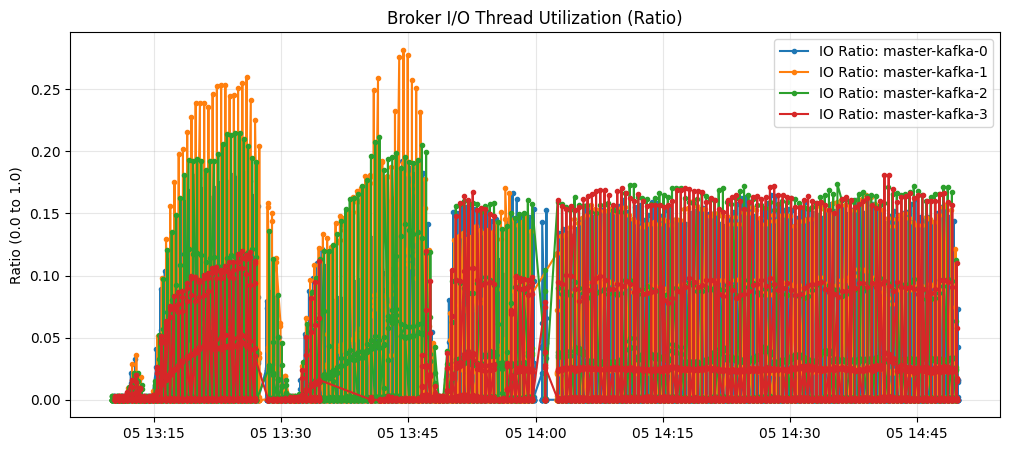

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Analyze IO Ratio (Busy-ness)
df_ratio = load_and_prepare(files['io_ratio'], columns=["kubernetes_pod_name", "value"])

plt.figure(figsize=(12, 5))
for pod, data in df_ratio.groupby('kubernetes_pod_name'):
    plt.plot(data.index, data['value'], label=f"IO Ratio: {pod}", marker='.')

plt.title("Broker I/O Thread Utilization (Ratio)")
plt.ylabel("Ratio (0.0 to 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

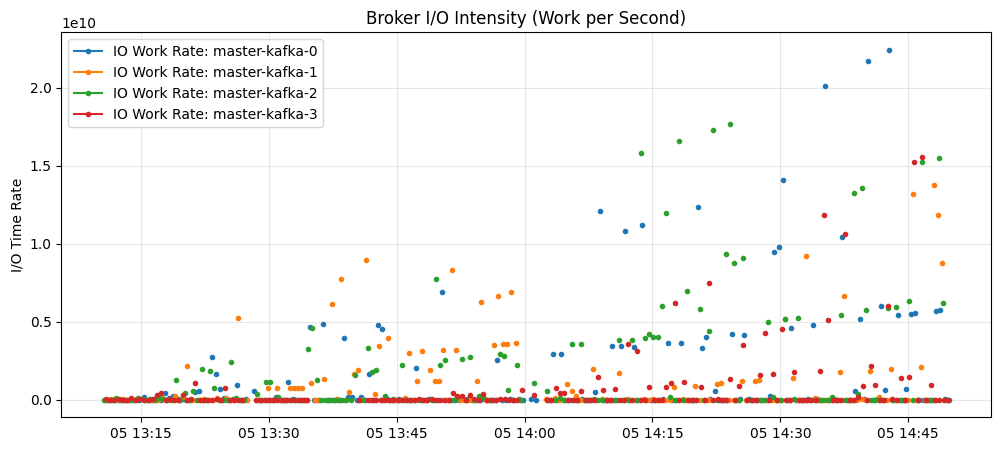

In [104]:
# 2. Analyze IO Time Rate
# IOTime is likely a counter, so we calculate the rate of change
df_iotime = load_and_prepare(files['io_time'], columns=["kubernetes_pod_name", "value"])

def calculate_io_rate(group):
    delta_val = group['value'].diff()
    delta_time = group.index.to_series().diff().dt.total_seconds()
    # Handle resets (negative delta)
    rate = delta_val / delta_time
    rate[delta_val < 0] = group['value'] / delta_time
    return rate

plt.figure(figsize=(12, 5))
for pod, data in df_iotime.groupby('kubernetes_pod_name'):
    # Ensure data is sorted for rate calculation
    data = data.sort_index()
    io_rate = calculate_io_rate(data)
    plt.plot(data.index, io_rate, label=f"IO Work Rate: {pod}", marker='.')

# plt.axvline(target_time_local, color='red', linestyle='--', label='Broker Restart')
plt.title("Broker I/O Intensity (Work per Second)")
plt.ylabel("I/O Time Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Messages Throughput

/tmp/ipykernel_190568/1266604371.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


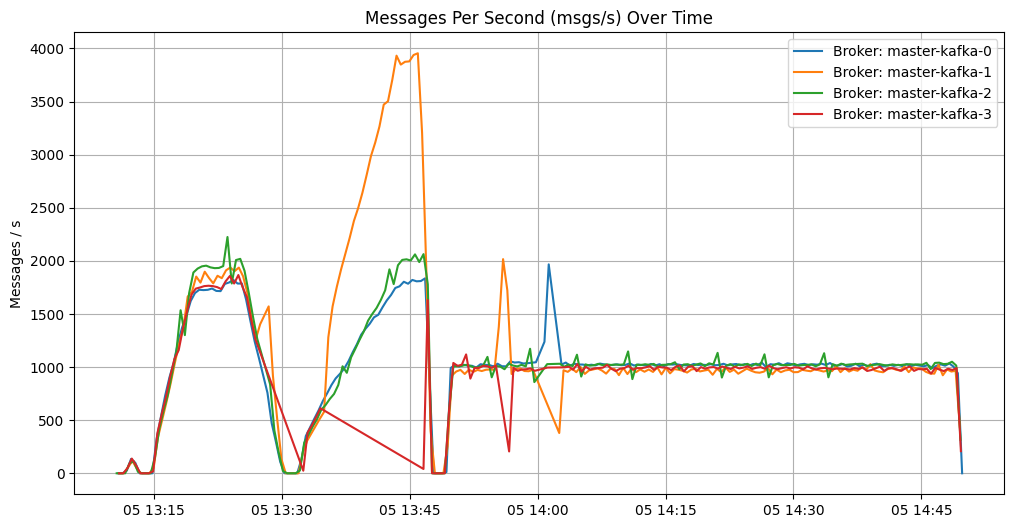

In [105]:
# 1. Analyze Messages Per Second (msgs/s)
df_msgs = load_and_prepare(files['messages'])
df_msgs = df_msgs[df_msgs["topic"] == "robot_data-avro"]
df_msgs = df_msgs.sort_values(["kubernetes_pod_name", "topic"])
if df_msgs is not None:
    df_msgs["rate"] = calculate_rate(df_msgs)

    df_msgs = df_msgs.dropna(subset=['rate'])
    
    plt.figure(figsize=(12, 6))
    for pod, data in df_msgs.groupby('kubernetes_pod_name'):
        plt.plot(data.index, data['rate'], label=f"Broker: {pod}")
    plt.title("Messages Per Second (msgs/s) Over Time")
    plt.ylabel("Messages / s")
    plt.legend()
    plt.grid(True)
    save_path = "../../data/processed/final-01/kafka_messages_per_second_cloud.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

/tmp/ipykernel_190568/1266604371.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)
/tmp/ipykernel_190568/1266604371.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


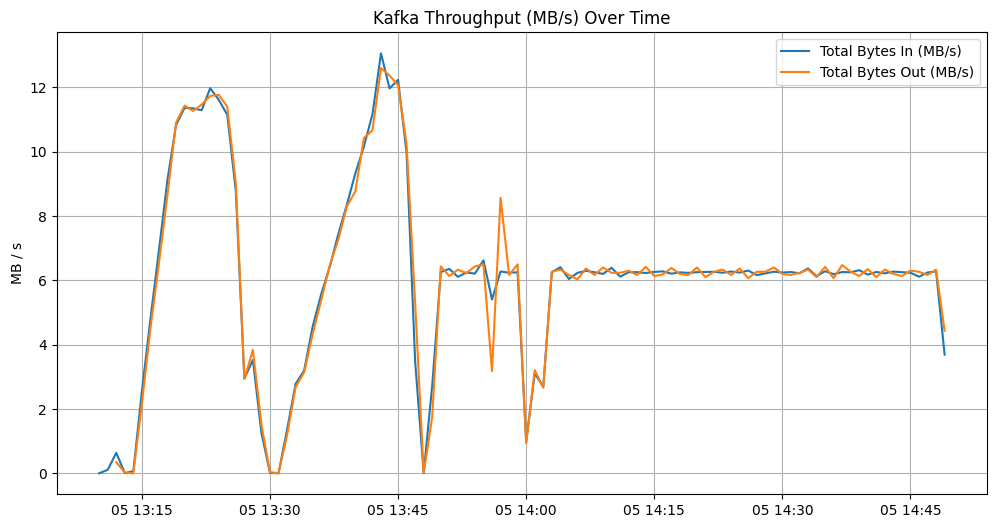

In [106]:
# 2. Analyze Bytes In and Out Over Time
df_bin = load_and_prepare(files['bytes_in'])
df_bin = df_bin[df_bin["topic"] == "robot_data-avro"]
df_bin = df_bin.sort_values(["kubernetes_pod_name", "topic"])
df_bout = load_and_prepare(files['bytes_out'])
df_bout = df_bout[df_bout["topic"] == "robot_data-avro"]
df_bout = df_bout.sort_values(["kubernetes_pod_name", "topic"])

if df_bin is not None and df_bout is not None:
    df_bin['bytes_in_per_sec'] = calculate_rate(df_bin)
    df_bout['bytes_out_per_sec'] = calculate_rate(df_bout)
    
    plt.figure(figsize=(12, 6))
    total_in = df_bin.resample('1Min')['bytes_in_per_sec'].sum()
    total_out = df_bout.resample('1Min')['bytes_out_per_sec'].sum()
    
    plt.plot(total_in.index, total_in / 1024**2, label="Total Bytes In (MB/s)")
    plt.plot(total_out.index, total_out / 1024**2, label="Total Bytes Out (MB/s)")
    plt.title("Kafka Throughput (MB/s) Over Time")
    plt.ylabel("MB / s")
    plt.legend()
    plt.grid(True)
    save_path = "../../data/processed/final-01/kafka_bytes_in_out_cloud.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    plt.show()

## Broker Sync

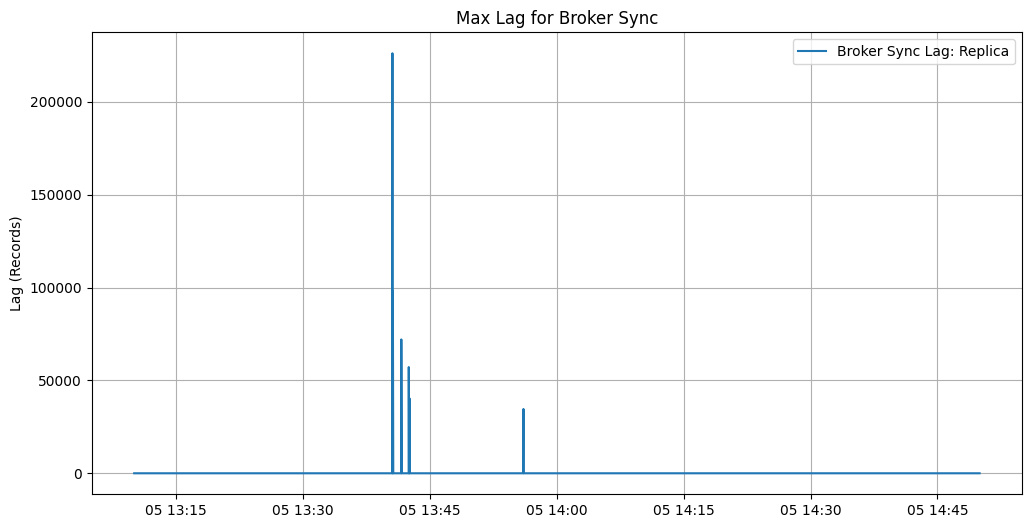

In [107]:
# 3. Analyze Lag for Broker Sync
df_lag = load_and_prepare(files['lag'], columns=["kubernetes_pod_name", "value", "clientId"])

if df_lag is not None:
    plt.figure(figsize=(12, 6))
    for client, data in df_lag.groupby('clientId'):
        plt.plot(data.index, data['value'], label=f"Broker Sync Lag: {client}")
    plt.title("Max Lag for Broker Sync")
    plt.ylabel("Lag (Records)")
    plt.legend()
    plt.grid(True)
    plt.show()

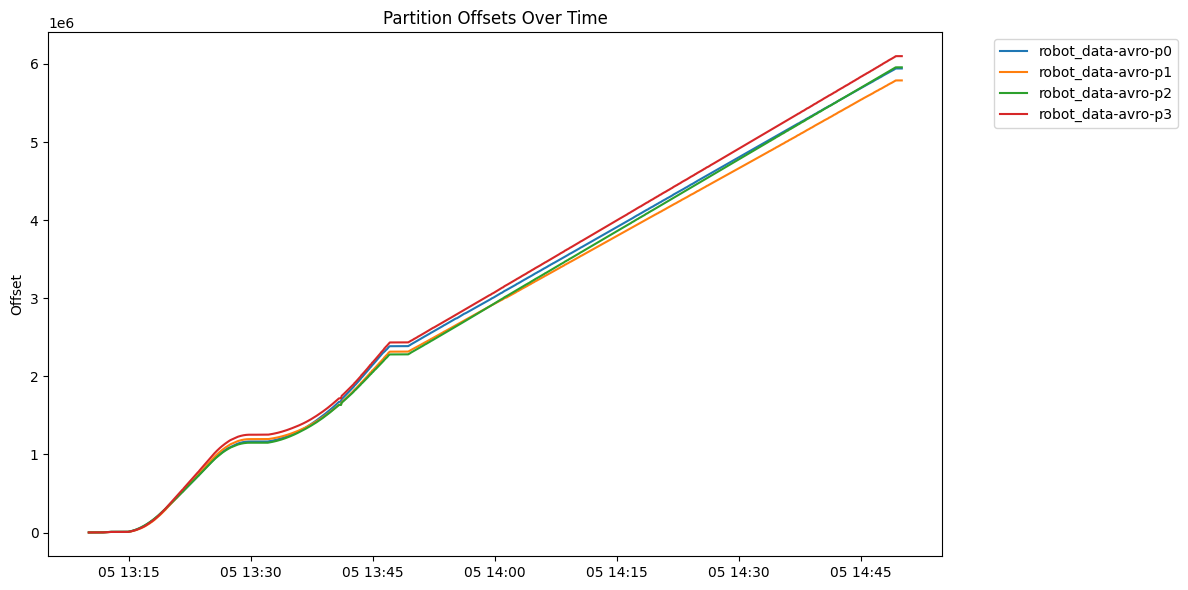

In [108]:
# 4. Offsets of Partitions Over Time
df_offsets = load_and_prepare(files['offsets'], columns=["value", "partition", "topic", "kubernetes_pod_name"])
df_offsets = df_offsets[df_offsets["topic"] == "robot_data-avro"]
if df_offsets is not None:
    plt.figure(figsize=(12, 6))
    # Plotting for a few specific partitions to avoid clutter
    for (topic, partition), data in df_offsets.groupby(['topic', 'partition']):
        plt.plot(data.index, data['value'], label=f"{topic}-p{partition}")
    plt.title("Partition Offsets Over Time")
    plt.ylabel("Offset")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()